# Regression using tree based algorithm

Estimate (i.e. make regression for) the energy of electrons. This should be based on maximum 15 variables from the Electron Variable List. The target variable for this task is "p_truth_E": Energy (in GeV) of the electrons, and you should only train on real (i.e. truth identified, "Truth==1") electrons. Note: It is an advantage to ONLY train the regression on true electrons (Truth = 1), but when submitting the solution, the regression estimate should be applied to ALL candidates, as you don't (perfectly) know, which are electrons, and which are not. We evaluate algorithm performance by considering Mean Absolute Error (MAE) on relative estimate accuracy: (E_pred-E_true)/E_true.

We start by opening the files and loading them into a Numpy array

In [1]:
import h5py
import pandas
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pandas.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

In [3]:
## temporarily use a fraction of the data to speed everything up
#train=train.sample(frac = 0.3)

Then we can verify the shape

In [4]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (162500, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [5]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and targets (`y`)

Only use the entries which we know are true electrons for training.


In [6]:
train = train.loc[train['Truth']==1]
X = train[all_variables]
y = train['p_truth_E']

print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')

Shape of X: (121495, 160)
Shape of y: (121495,)


In [7]:
X.head(2)

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
0,26.5,26.5,26.5,26.5,26.5,26.5,18,3,42011.792969,1.834715,...,215.588013,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594
3,37.5,37.5,37.5,37.5,37.5,37.5,17,2,44975.042969,-2.023659,...,0.000000,27372.955078,104002.000000,921.178040,0.000000,27101.673828,106995.789062,1127.115356,0.000000,27101.673828


In [8]:
#!pip install seaborn update

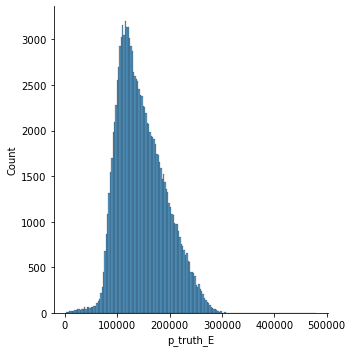

In [9]:
sns.displot(data=train, x=y)

## Preprocessing

### Check null values

In [10]:
train.isnull().sum()

eventNumber                       0
runNumber                         0
actualInteractionsPerCrossing     0
averageInteractionsPerCrossing    0
correctedActualMu                 0
                                 ..
p_E7x11_Lr2                       0
p_E7x11_Lr3                       0
p_E7x7_Lr0                        0
p_E7x7_Lr1                        0
index                             0
Length: 166, dtype: int64

No nulls
### Scale the data

In [11]:
transformed_X = deepcopy(X) 
# This loop transforms every variable _independently_ 
for variable in X.columns:     
    transformed_X[variable] = RobustScaler().fit_transform(np.array(transformed_X[variable]).reshape(-1,1))

### Select k Best features

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

In [13]:
X_15 = SelectKBest(score_func=f_regression, k=15).fit_transform(X, y)
X_15.shape

/Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/niallgray/opt/miniconda3/envs/aml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


(121495, 15)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_15,y,test_size=.3, random_state=42)

In [15]:
from sklearn.metrics import mean_absolute_error

# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))


Baseline MAE is 36932.90


## XGBoost regression

In [14]:
# xgboost for regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# evaluate the model
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_15, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# fit the model on the whole dataset
model = XGBRegressor(objective='reg:squarederror')
model.fit(X, y)


MAE: -6641.574 (87.158)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

## LightGBM regression

In [15]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# evaluate the model
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_15, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# fit the model on the whole dataset
model = LGBMRegressor()
model.fit(X, y)


MAE: -6548.651 (74.833)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Hyperparameter tuning

### Random Search

In [18]:
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1, verbose=1)
# execute search
result = search.fit(X_15, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 500 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 12784 tasks      |

Best Score: -6462.42947586077
Best Hyperparameters: {'alpha': 0.0002531181460133387, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}


[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed: 57.1min finished


### Grid Search

In [16]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
# execute search
result = search.fit(X_15, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 128 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 14.4min finished


Best Score: -6464.314837511495
Best Hyperparameters: {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = XGBRegressor()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
# parameters = {
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}
parameters = {
              #'objective':['reg:square'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 300, 500, 700]}
# define search
search = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
# execute search
result = search.fit(X_15, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 4 candidates, totalling 120 fits
[17:46:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Score: -6529.302278645833
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 700, 'silent': 1, 'subsample': 0.7}


In [23]:
# import joblib

# #save your model or results
# joblib.dump(search, 'XGBReg_gridsearch_result.pkl')

In [24]:
# loaded_result = joblib.load("XGBReg_gridsearch_result.pkl")

# # summarize result
# print('Best Score: %s' % loaded_result.best_score_)
# print('Best Hyperparameters: %s' % loaded_result.best_params_)

## Bayesian optimisation of hyperparameters and cross validation

In [26]:
# from xgboost import XGBRegressor

In [19]:
def XGB_CrossValidation(eta, learning_rate, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations
       that maximize the accuracy
    """
    
    estimator = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                                 max_depth=max_depth, random_state=0)
    
    cval = cross_val_score(estimator, data, targets, scoring='accuracy', cv=5)
    
    return cval.mean()

In [ ]:
def optimize_XGB(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(n_estimators, learning_rate, max_depth):
        """Wrapper of Decision Tree cross validation. 
           max_depth and n_estimators
           are cast to integer before we pass them along.
        """
        return XGB_CrossValidation(n_estimators=int(n_estimators), 
                                            learning_rate=learning_rate, 
                                            max_depth=int(max_depth),
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [ ]:
parameters_BayesianOptimization = {"learning_rate": (0.0001, 1), 
                                   "max_depth": (1, 5),
                                   "n_estimators": (50,500)
                                  }

BayesianOptimization = optimize_XGB(X_15, 
                                             y, 
                                             parameters_BayesianOptimization, 
                                             n_iter=5)
print(BayesianOptimization.max)

In [ ]:
'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}